Welcome to the INTERA GW Modeling TAC MODFLOW6 API Demo!

First we import our standard python libraries, as well as the pertinent packages for this tutorial: FloPy and modflowapi.

In [1]:
import numpy as np
import pandas as pd
import shutil
import os
import matplotlib.pyplot as plt
import platform
import modflowapi
import flopy
from IPython.display import HTML

Then we need to set the path for our standard mf6 executable using the platform package which can detect your OS and assign the paths accordingly. We also need to set the path for the modflow6 api shared library (libmf6.dll for windows), which is what we will actually use to run the api and interact with the simualtion. 

In [2]:
if "linux" in platform.platform().lower():
    lib_path = os.path.join("bin","linux","libmf6.so")
    exe_path = os.path.join("bin","linux","mf6")
    lib_name = os.path.split(lib_path)[-1]
    exe_name = "./"+os.path.split(exe_path)[-1]
elif "darwin" in platform.platform().lower() or "macos" in platform.platform().lower() :
    lib_path = os.path.join("bin","mac","libmf6.so")
    exe_path = os.path.join("bin","mac","mf6")
    lib_name = os.path.split(lib_path)[-1]
    exe_name = "./"+os.path.split(exe_path)[-1]
else:
    lib_path = os.path.join("bin","win","libmf6.dll")
    exe_path = os.path.join("bin","win","mf6.exe")  
    lib_name = os.path.split(lib_path)[-1]
    exe_name = os.path.split(exe_path)[-1]

Assuming that worked, next we will create a copy of the freyberg test model to work with. This is good practice for any python modeling workflows, as it allows us to leave the base files untouched and keep a python record of what is changed about it!

In [3]:
org_dir = "freyberg_monthly"
work_dir = "temp"
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)
shutil.copytree(org_dir,work_dir)
shutil.copy2(lib_path,os.path.join(work_dir,os.path.split(lib_path)[-1]))
shutil.copy2(exe_path,os.path.join(work_dir,os.path.split(exe_path)[-1]))

'temp\\mf6.exe'

Now we run the temp model using the standard executable, to make sure it runs to completion. 

In [4]:
c_d = os.getcwd()
os.chdir(work_dir)
os.system(exe_name)
os.chdir(c_d)

Now lets see how the API works. First let's make a new model copy and replicate the standard MF6 solution with the API

In [5]:
api_dir1 = "api1"
if os.path.exists(api_dir1):
    shutil.rmtree(api_dir1)
shutil.copytree(org_dir,api_dir1)
shutil.copy2(lib_path,os.path.join(api_dir1,os.path.split(lib_path)[-1]))
shutil.copy2(exe_path,os.path.join(api_dir1,os.path.split(exe_path)[-1]))

'api1\\mf6.exe'

The first thing you need to do is create the api object instance by calling modflowapi.ModflowApi() and specifying the arguments for the path to the shared library as well as the working directory. Then we "initialize" that object, which we are calling gwf for groundwater flow. 

In [6]:
gwf = modflowapi.ModflowApi(os.path.join(api_dir1, lib_name), working_directory=api_dir1)
gwf.initialize()

Then, before marching through the simulation, we need to first get the current time (which is the start time initially) and end time, as well as the maximum number of iterations (specified in IMS)

In [7]:
# get current sim time
ctime = gwf.get_current_time()
# get ending sim time
etime = gwf.get_end_time()
# max number of iterations
max_iter = gwf.get_value(gwf.get_var_address("MXITER", "SLN_1"))

Then, we wrap the api in a while loop and march the solution forward until we reach the simulation end time. The basic steps of marching through a simulation are as follows:
1. Get the current time step length with `gwf.get_time_step()`
2. Prepare the time step with `gwf.prepare_time_step(dt)`
3. Prepare the solution with `gwf.prepare_solve(1)`
4. Try solving the current iteration with `gwf.solve(1)`. If it doesn't solve, then add 1 to the iteration and try the solution again. do this until solution is achieved or the maximum number of iterations is reached.
5. Finalize the solution for the time step with `gwf.finalize_solve(1)`
6. Finalize the time step with `gwf.finalize_time_step()`
7. Get the current time with `ctime = gwf.get_current_time()`
8. Repeat steps 1-7 for all timesteps until end time is reached, and then finalize the api object with `gwf.finalize()`

In [8]:
# let's do it!
while ctime < etime:
    # the length of this sim time
    dt = gwf.get_time_step()
    # prep the current time step
    gwf.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    gwf.prepare_solve(1)
    # the current one-based stress period number
    stress_period = gwf.get_value(gwf.get_var_address("KPER", "TDIS"))[0]
    time_step = gwf.get_value(gwf.get_var_address("KSTP", "TDIS"))[0]
    # solve until converged
    while kiter < max_iter:
        if gwf.solve(1):
            print("flow stress period,time step {0},{1} converged with {2} iters".\
                  format(stress_period, time_step, kiter))
            break

        kiter += 1
    try:
        gwf.finalize_solve(1)
    except:
        pass

    gwf.finalize_time_step()
    # update current sim time
    ctime = gwf.get_current_time()
gwf.finalize()

flow stress period,time step 1,1 converged with 5 iters
flow stress period,time step 2,1 converged with 1 iters
flow stress period,time step 3,1 converged with 1 iters
flow stress period,time step 4,1 converged with 1 iters
flow stress period,time step 5,1 converged with 1 iters
flow stress period,time step 6,1 converged with 1 iters
flow stress period,time step 7,1 converged with 1 iters
flow stress period,time step 8,1 converged with 1 iters
flow stress period,time step 9,1 converged with 1 iters
flow stress period,time step 10,1 converged with 1 iters
flow stress period,time step 11,1 converged with 1 iters
flow stress period,time step 12,1 converged with 1 iters
flow stress period,time step 13,1 converged with 1 iters
flow stress period,time step 14,1 converged with 1 iters
flow stress period,time step 15,1 converged with 1 iters
flow stress period,time step 16,1 converged with 1 iters
flow stress period,time step 17,1 converged with 1 iters
flow stress period,time step 18,1 conver

Now let's do something more exciting. We can use the API interface to build in operational rules for the pumping wells. If the sfr downstream flow for the terminal reach is too low, we need to pump less, if the flow is high, we can pump more. First we need to create a new working directory, and then intitialize an API GWF model.

In [9]:
api_dir2 = "api2"
if os.path.exists(api_dir2):
    shutil.rmtree(api_dir2)
shutil.copytree(org_dir,api_dir2)
shutil.copy2(lib_path,os.path.join(api_dir2,os.path.split(lib_path)[-1]))
shutil.copy2(exe_path,os.path.join(api_dir2,os.path.split(exe_path)[-1]))

'api2\\mf6.exe'

In [10]:
gwf = modflowapi.ModflowApi(os.path.join(api_dir2, lib_name), working_directory=api_dir2)
gwf.initialize()

Before we go further, we need to pause and take a look at the MF6 memory manager. In the OPTIONS block of mfsim.nam, add the following key and value: MEMORY_PRINT_OPTION ALL and then run the MF6 model. Open mfsim.lst and scroll to the bottom until you see the line: "DETAILED INFORMATION ON VARIABLES STORED IN THE MEMORY MANAGER"

In [1]:
HTML("""
<video width="320" height="240" controls>
  <source src="mem_mgr.mp4" type="video/mp4">
</video>
""")

NameError: name 'HTML' is not defined

Here you will find all packages and variables being used in the model (and therefore stored in memory). This is your key to accessing model properties, boundary conditions, and basically anything else involved in the numerical solution using the API. You will notice that we have already sneakily used this in just running the standard MF6 solution with the API with `max_iter = gwf.get_value(gwf.get_var_address("MXITER", "SLN_1"))`

There are essentially three steps to acquiring and modifying properties, BCs, etc. from within the API solution.
1. Create an object of the address. This is the variable name, model name, and origin, in that order. So for K, it would be `addr = ["K11", "FREYBERG6", "NPF"]`. Note that model solution parameters do not require model name in their address. Try to come up with the address for DELR. 
2. Get the variable address using the API with `wbaddr = gwf.get_var_address(*addr)`
3. Get the value(s) of the variable using the API with `gwf.get_value_ptr(wbaddr)` or `gwf.get_value(wbaddr)`. The main difference is whether you plan to modify the value or just need a copy of the value. `get_value_ptr` is for modifying, `get_value` is for copying. You will see both in use below.

Now we will march thru stess periods as before, but within the outer iteration loop, we will attempt some "management" to link the groundwater extraction rates to surface-water flow. If the surface-water flow at the terminal downstream reach is less than 2,500, reduce the pumping rates. Otherwise, if the surface-water flow is greater than 3,000, lets pump more!

In [12]:
# get current sim time
ctime = gwf.get_current_time()
# get ending sim time
etime = gwf.get_end_time()
# max number of iterations
max_iter = gwf.get_value(gwf.get_var_address("MXITER", "SLN_1"))
# let's do it!
while ctime < etime:
    # the length of this sim time
    dt = gwf.get_time_step()
    # prep the current time step
    gwf.prepare_time_step(dt)
    kiter = 0
    # prep to solve
    gwf.prepare_solve(1)
    # the current one-based stress period number
    stress_period = gwf.get_value(gwf.get_var_address("KPER", "TDIS"))[0]
    time_step = gwf.get_value(gwf.get_var_address("KSTP", "TDIS"))[0]
    # solve until converged
    while kiter < max_iter:
        
        # get the sfr dsflow rate for the last reach
        addr = ["DSFLOW", "FREYBERG6", "SFR_1"]
        wbaddr = gwf.get_var_address(*addr)
        sfr_dsflow = gwf.get_value(wbaddr)
        
        #get the wel extraction rates
        "FREYBERG6/WEL-1                   BOUND"
        addr = ["BOUND", "FREYBERG6", "WEl-1"]
        wbaddr = gwf.get_var_address(*addr)
        wel_bound = gwf.get_value_ptr(wbaddr)
        org = np.sum(wel_bound)
        
        # if the flow is too low, turn down the wells
        fac = 1
        if sfr_dsflow[-1] < 2500:
            fac = sfr_dsflow[-1]/2500
            wel_bound[:] *= fac
        
        #otherewise if there is extra flow, turn up the wells
        elif sfr_dsflow[-1] > 3000:
            fac = sfr_dsflow[-1]/3000
            wel_bound[:] *= fac
        
        # if we have solved at least once and the solution is converged
        if gwf.solve(1) and kiter > 1:
            # get the sfr dsflow rate for the last reach
            addr = ["DSFLOW", "FREYBERG6", "SFR_1"]
            wbaddr = gwf.get_var_address(*addr)
            sfr_dsflow = gwf.get_value(wbaddr)
            print("flow stress period,time step {0},{1} converged with {2} iters, final sfr:{3:5.2f}".\
                  format(stress_period,time_step, kiter,sfr_dsflow[-1]))
            break
        
        
        print("  ---  iter:{0}, sfr:{1:5.2f} org wel:{2:5.2f} new wel:{3:5.2f} fac:{4:2.1f}" .\
              format(kiter,sfr_dsflow[-1],org,np.sum(wel_bound),fac))
        kiter += 1
    try:
        gwf.finalize_solve(1)
    except:
        pass
    
    
    gwf.finalize_time_step()
    # update current sim time
    ctime = gwf.get_current_time()
gwf.finalize()

  ---  iter:0, sfr: 0.00 org wel:-900.00 new wel: 0.00 fac:0.0
  ---  iter:1, sfr:3907.46 org wel: 0.00 new wel: 0.00 fac:1.3
  ---  iter:2, sfr:4339.91 org wel: 0.00 new wel: 0.00 fac:1.4
  ---  iter:3, sfr:3410.25 org wel: 0.00 new wel: 0.00 fac:1.1
  ---  iter:4, sfr:3027.47 org wel: 0.00 new wel: 0.00 fac:1.0
flow stress period,time step 1,1 converged with 5 iters, final sfr:2983.33
  ---  iter:0, sfr:2983.33 org wel:-900.05 new wel:-900.05 fac:1.0
  ---  iter:1, sfr:2981.59 org wel:-900.05 new wel:-900.05 fac:1.0
flow stress period,time step 2,1 converged with 2 iters, final sfr:3133.72
  ---  iter:0, sfr:3133.72 org wel:-900.53 new wel:-940.67 fac:1.0
  ---  iter:1, sfr:3132.30 org wel:-940.67 new wel:-982.16 fac:1.0
  ---  iter:2, sfr:3546.74 org wel:-982.16 new wel:-1161.15 fac:1.2
  ---  iter:3, sfr:3551.57 org wel:-1161.15 new wel:-1374.64 fac:1.2
  ---  iter:4, sfr:3535.95 org wel:-1374.64 new wel:-1620.22 fac:1.2
  ---  iter:5, sfr:3479.65 org wel:-1620.22 new wel:-1879.26 

flow stress period,time step 16,1 converged with 14 iters, final sfr:3002.79
  ---  iter:0, sfr:3002.79 org wel:-900.14 new wel:-900.98 fac:1.0
  ---  iter:1, sfr:3000.57 org wel:-900.98 new wel:-901.15 fac:1.0
  ---  iter:2, sfr:3746.28 org wel:-901.15 new wel:-1125.32 fac:1.2
  ---  iter:3, sfr:3767.68 org wel:-1125.32 new wel:-1413.28 fac:1.3
  ---  iter:4, sfr:3754.56 org wel:-1413.28 new wel:-1768.74 fac:1.3
  ---  iter:5, sfr:3675.39 org wel:-1768.74 new wel:-2166.94 fac:1.2
  ---  iter:6, sfr:3589.66 org wel:-2166.94 new wel:-2592.86 fac:1.2
  ---  iter:7, sfr:3503.70 org wel:-2592.86 new wel:-3028.20 fac:1.2
  ---  iter:8, sfr:3412.60 org wel:-3028.20 new wel:-3444.68 fac:1.1
  ---  iter:9, sfr:3319.26 org wel:-3444.68 new wel:-3811.26 fac:1.1
  ---  iter:10, sfr:3229.51 org wel:-3811.26 new wel:-4102.83 fac:1.1
  ---  iter:11, sfr:3149.95 org wel:-4102.83 new wel:-4307.90 fac:1.0
  ---  iter:12, sfr:3086.26 org wel:-4307.90 new wel:-4431.77 fac:1.0
  ---  iter:13, sfr:3041.12 

Woah - that drastically increased the number of iterations - we are working the solver here with some strong nonlinearity! Let's plot up the results and check the differences between the standard and the API run

Text(0.5, 1.0, 'sw-gw flux')

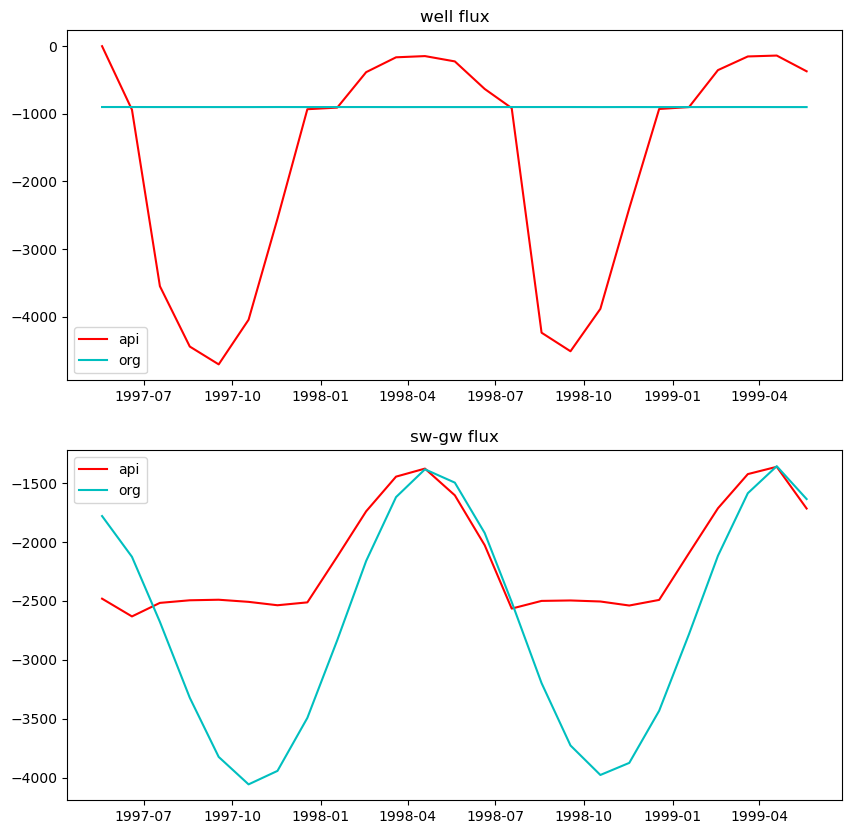

In [13]:
lst_org = flopy.utils.Mf6ListBudget(os.path.join(work_dir,"freyberg6.lst"))
lst_api = flopy.utils.Mf6ListBudget(os.path.join(api_dir2,"freyberg6.lst"))

oinc,ocum = lst_org.get_dataframes(diff=True)
ainc,acum = lst_api.get_dataframes(diff=True)

fig,axes = plt.subplots(2,1,figsize=(10,10))
axes[0].plot(ainc.index,ainc.wel,color="r",label="api")
axes[0].plot(oinc.index,oinc.wel,color="c",label="org")
axes[1].plot(ainc.index,ainc.sfr,color="r",label="api")
axes[1].plot(oinc.index,oinc.sfr,color="c",label="org")
axes[0].legend()
axes[0].set_title("well flux")
axes[1].legend()
axes[1].set_title("sw-gw flux")

We can see the effect of our "management" strategy: substantially more gw is extracted during the wet season while less groundwater is extracted during the dry season compared to the original simulation (that used constant extraction). And we see that this contributes to less groundwater contribution to surface water during the wet season.

Now that you've seen the API in action for a simple conjunctive use scenario, try coding up your own to accomplish the following: 

Pick a head located anywhere in layer 1 and set an arbitrary minimum threshold, that, when surpassed, leads to a system-wide pumping reduction. Hint: the address for current timestep head is `['X', 'FREYBERG6']`

You can adapt the following code to plot up the results to check that the WL recovers and check that pumping is reduced.